In [ ]:


# puis monter
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Paramètres ===
BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 70
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LR = 2e-4
SAVE_INTERVAL = 10



# === Dossiers ===
base_model_dir = "/content/drive/MyDrive/controls_right"  # Poids préentraînés
fine_tune_model_dir = "/content/drive/MyDrive/controls_right/saved_models_controls_right"
sample_dir = "/content/drive/MyDrive/controls_right/generated_samples_controls_right"
data_path = "/content/drive/MyDrive/controls_right/controls_all_right.npz"

os.makedirs(fine_tune_model_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# === Construction du générateur et du critic ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1200, 1)),

        tf.keras.layers.Conv1D(64, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(128, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(256, 15, strides=3, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# === Initialisation ===
generator = build_generator()
critic = build_critic()

generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
critic_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

# === Charger les poids préentraînés sur "controls" ===
generator.load_weights(f"{base_model_dir}/generator_epoch_250.weights.h5")
critic.load_weights(f"{base_model_dir}/critic_epoch_250.weights.h5")
print("✓ Poids préentraînés chargés depuis les sujets contrôles")

# === Chargement des données controls right ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# === Gradient Penalty ===
def gradient_penalty(real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    return tf.reduce_mean((slopes - 1.)**2)

# === Entraînement ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
history = {'critic': [], 'gen': []}

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Critic
    for _ in range(CRITIC_STEPS):
        with tf.GradientTape() as tape:
            fake = generator(noise, training=True)
            real_out = critic(batch, training=True)
            fake_out = critic(fake, training=True)

            gp = gradient_penalty(batch, fake)
            c_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + GP_WEIGHT * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Generator
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        g_loss = -tf.reduce_mean(critic(fake, training=True))

    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return c_loss, g_loss

# === Boucle d'entraînement ===
for epoch in range(EPOCHS):
    epoch_c_loss = []
    epoch_g_loss = []

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        c_loss, g_loss = train_step(batch)
        epoch_c_loss.append(c_loss)
        epoch_g_loss.append(g_loss)

    avg_c_loss = tf.reduce_mean(epoch_c_loss)
    avg_g_loss = tf.reduce_mean(epoch_g_loss)

    history['critic'].append(avg_c_loss.numpy())
    history['gen'].append(avg_g_loss.numpy())

    print(f"\nEpoch {epoch+1} | Critic: {avg_c_loss:.4f} | Generator: {avg_g_loss:.4f}")

    # Sauvegarde périodique
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generator.save_weights(f'{fine_tune_model_dir}/generator_epoch_{epoch+1}.weights.h5')
        critic.save_weights(f'{fine_tune_model_dir}/critic_epoch_{epoch+1}.weights.h5')

        samples = generator(fixed_noise)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(5, 1, i+1)
            plt.plot(samples[i, :, 0])
            plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(f'{sample_dir}/epoch_{epoch+1}.png')
        plt.close()

print("✓ Fine-tuning terminé pour controls pied droite")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


✓ Poids préentraînés chargés depuis les sujets contrôles


Epoch 1/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 1 | Critic: -1.1379 | Generator: -6.9235


Epoch 2/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 2 | Critic: -1.1101 | Generator: -0.9280


Epoch 3/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 3 | Critic: -1.0868 | Generator: 2.5384


Epoch 4/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 4 | Critic: -1.0927 | Generator: -14.8984


Epoch 5/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 5 | Critic: -0.9822 | Generator: -12.8275


Epoch 6/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 6 | Critic: -0.8086 | Generator: -8.2733


Epoch 7/70: 100%|██████████| 17/17 [04:01<00:00, 14.19s/it]



Epoch 7 | Critic: -0.7977 | Generator: -2.7946


Epoch 8/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 8 | Critic: -1.0784 | Generator: -6.7424


Epoch 9/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 9 | Critic: -1.3104 | Generator: -7.8902


Epoch 10/70: 100%|██████████| 17/17 [04:00<00:00, 14.17s/it]



Epoch 10 | Critic: -1.1059 | Generator: -8.1224


Epoch 11/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 11 | Critic: -0.7148 | Generator: -4.3680


Epoch 12/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 12 | Critic: -0.9698 | Generator: -1.0674


Epoch 13/70: 100%|██████████| 17/17 [03:59<00:00, 14.06s/it]



Epoch 13 | Critic: -1.0965 | Generator: 13.9009


Epoch 14/70: 100%|██████████| 17/17 [03:56<00:00, 13.93s/it]



Epoch 14 | Critic: -1.0656 | Generator: 1.6334


Epoch 15/70: 100%|██████████| 17/17 [03:57<00:00, 13.98s/it]



Epoch 15 | Critic: -0.7766 | Generator: -1.2593


Epoch 16/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 16 | Critic: -0.8624 | Generator: 2.0649


Epoch 17/70: 100%|██████████| 17/17 [03:56<00:00, 13.89s/it]



Epoch 17 | Critic: -0.9918 | Generator: 4.9101


Epoch 18/70: 100%|██████████| 17/17 [03:56<00:00, 13.90s/it]



Epoch 18 | Critic: -1.1984 | Generator: 15.4315


Epoch 19/70: 100%|██████████| 17/17 [03:57<00:00, 13.97s/it]



Epoch 19 | Critic: -1.1736 | Generator: 3.7772


Epoch 20/70: 100%|██████████| 17/17 [03:56<00:00, 13.93s/it]



Epoch 20 | Critic: -0.8715 | Generator: -4.1641


Epoch 21/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 21 | Critic: -1.0789 | Generator: -2.6212


Epoch 22/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 22 | Critic: -0.8901 | Generator: -3.2178


Epoch 23/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 23 | Critic: -1.0089 | Generator: -1.1233


Epoch 24/70: 100%|██████████| 17/17 [03:57<00:00, 13.96s/it]



Epoch 24 | Critic: -0.7514 | Generator: 3.5048


Epoch 25/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 25 | Critic: -0.9742 | Generator: 4.9946


Epoch 26/70: 100%|██████████| 17/17 [03:57<00:00, 14.00s/it]



Epoch 26 | Critic: -1.1412 | Generator: 0.1986


Epoch 27/70: 100%|██████████| 17/17 [03:57<00:00, 13.95s/it]



Epoch 27 | Critic: -1.0023 | Generator: 1.3374


Epoch 28/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 28 | Critic: -1.1373 | Generator: 9.7270


Epoch 29/70: 100%|██████████| 17/17 [03:59<00:00, 14.06s/it]



Epoch 29 | Critic: -0.8823 | Generator: 7.3739


Epoch 30/70: 100%|██████████| 17/17 [03:56<00:00, 13.92s/it]



Epoch 30 | Critic: -1.0876 | Generator: 12.1659


Epoch 31/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 31 | Critic: -1.0619 | Generator: 19.9905


Epoch 32/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 32 | Critic: -1.0443 | Generator: 10.0217


Epoch 33/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 33 | Critic: -0.9067 | Generator: 4.1352


Epoch 34/70: 100%|██████████| 17/17 [03:57<00:00, 13.96s/it]



Epoch 34 | Critic: -1.0478 | Generator: 1.3703


Epoch 35/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 35 | Critic: -0.8454 | Generator: 3.5954


Epoch 36/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 36 | Critic: -1.0202 | Generator: 9.2568


Epoch 37/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 37 | Critic: -1.2774 | Generator: 15.4823


Epoch 38/70: 100%|██████████| 17/17 [03:58<00:00, 14.03s/it]



Epoch 38 | Critic: -1.0316 | Generator: 7.8302


Epoch 39/70: 100%|██████████| 17/17 [03:58<00:00, 14.00s/it]



Epoch 39 | Critic: -1.1925 | Generator: -5.5240


Epoch 40/70: 100%|██████████| 17/17 [03:57<00:00, 13.95s/it]



Epoch 40 | Critic: -1.1953 | Generator: 4.1768


Epoch 41/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 41 | Critic: -0.9447 | Generator: 2.1250


Epoch 42/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 42 | Critic: -0.9471 | Generator: -3.4808


Epoch 43/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 43 | Critic: -1.0174 | Generator: -2.0474


Epoch 44/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 44 | Critic: -0.7916 | Generator: 5.1042


Epoch 45/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 45 | Critic: -0.8552 | Generator: 3.3726


Epoch 46/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 46 | Critic: -1.1020 | Generator: 3.3080


Epoch 47/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 47 | Critic: -0.8732 | Generator: 3.2038


Epoch 48/70: 100%|██████████| 17/17 [03:58<00:00, 14.02s/it]



Epoch 48 | Critic: -1.0482 | Generator: 5.6223


Epoch 49/70: 100%|██████████| 17/17 [03:57<00:00, 13.95s/it]



Epoch 49 | Critic: -1.0217 | Generator: 10.5456


Epoch 50/70: 100%|██████████| 17/17 [03:58<00:00, 14.00s/it]



Epoch 50 | Critic: -1.0997 | Generator: 7.8326


Epoch 51/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 51 | Critic: -0.8195 | Generator: -1.6127


Epoch 52/70: 100%|██████████| 17/17 [03:57<00:00, 13.97s/it]



Epoch 52 | Critic: -0.9611 | Generator: -1.6420


Epoch 53/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 53 | Critic: -1.1515 | Generator: 3.5377


Epoch 54/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 54 | Critic: -1.0242 | Generator: -0.2950


Epoch 55/70: 100%|██████████| 17/17 [03:56<00:00, 13.93s/it]



Epoch 55 | Critic: -1.0263 | Generator: 0.1135


Epoch 56/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 56 | Critic: -1.0342 | Generator: -2.8181


Epoch 57/70: 100%|██████████| 17/17 [03:58<00:00, 14.04s/it]



Epoch 57 | Critic: -0.9167 | Generator: -1.8169


Epoch 58/70: 100%|██████████| 17/17 [03:56<00:00, 13.88s/it]



Epoch 58 | Critic: -0.9401 | Generator: 1.7194


Epoch 59/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 59 | Critic: -1.2890 | Generator: -1.1407


Epoch 60/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 60 | Critic: -0.9213 | Generator: -1.4424


Epoch 61/70: 100%|██████████| 17/17 [03:56<00:00, 13.91s/it]



Epoch 61 | Critic: -0.9764 | Generator: -0.1700


Epoch 62/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 62 | Critic: -0.9577 | Generator: -0.0651


Epoch 63/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 63 | Critic: -0.9288 | Generator: -1.5863


Epoch 64/70: 100%|██████████| 17/17 [03:58<00:00, 14.00s/it]



Epoch 64 | Critic: -0.9333 | Generator: -3.2073


Epoch 65/70: 100%|██████████| 17/17 [03:57<00:00, 13.94s/it]



Epoch 65 | Critic: -0.9947 | Generator: -4.4784


Epoch 66/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 66 | Critic: -0.9051 | Generator: -2.6808


Epoch 67/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 67 | Critic: -0.9879 | Generator: -8.6495


Epoch 68/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 68 | Critic: -1.0217 | Generator: -3.9944


Epoch 69/70: 100%|██████████| 17/17 [03:58<00:00, 14.01s/it]



Epoch 69 | Critic: -0.8225 | Generator: -4.9604


Epoch 70/70: 100%|██████████| 17/17 [04:21<00:00, 15.41s/it]



Epoch 70 | Critic: -1.0918 | Generator: 5.5385
✓ Fine-tuning terminé pour controls pied droite


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


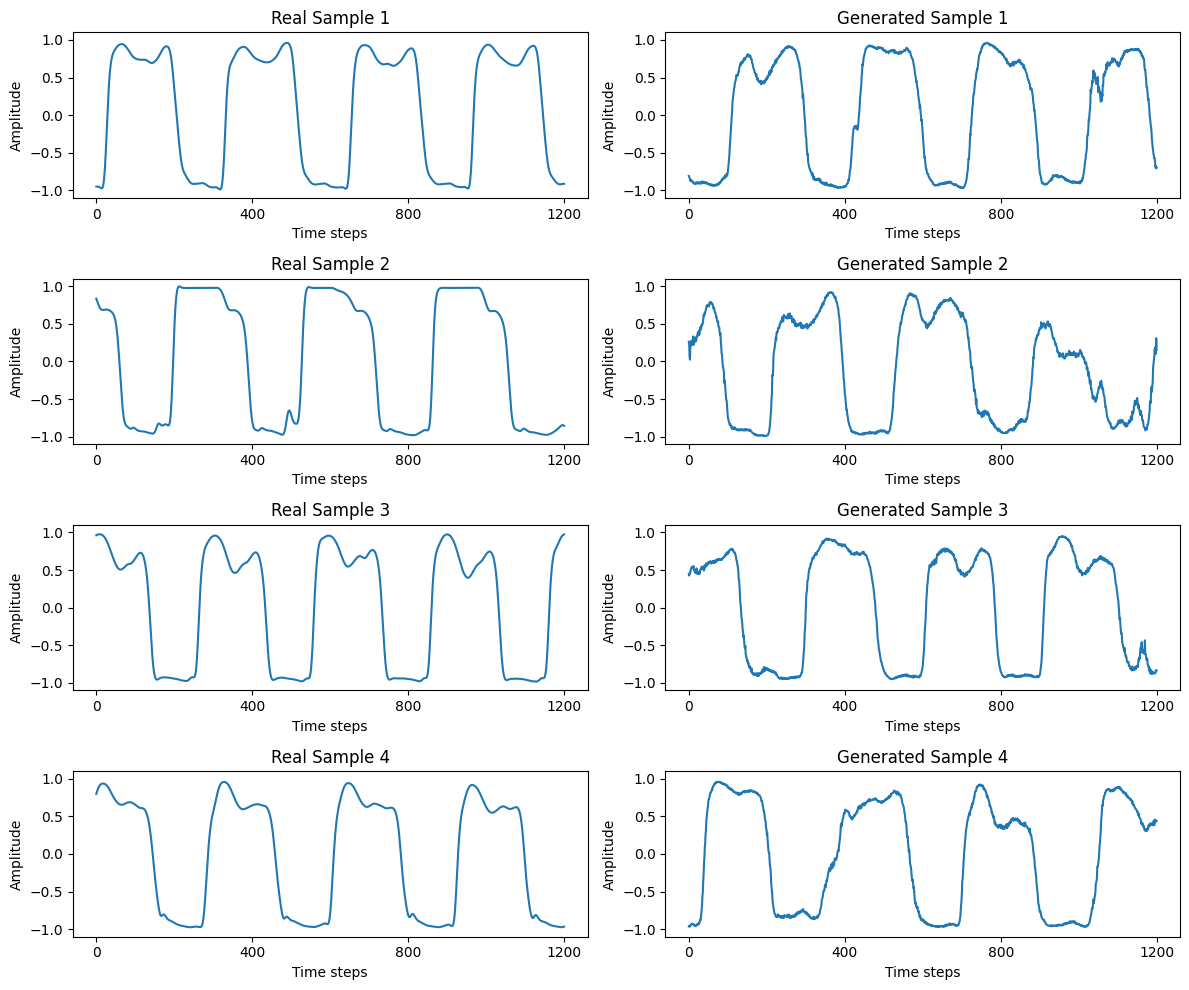

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt




# Parameters
NOISE_DIM = 64
num_samples = 4  # Match the number of samples in your image

# Define generator (same as in your training code)
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# Load real data
data_path = "/content/drive/MyDrive/controls_right/controls_all_right.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1  # Normalize to [-1, 1]
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# Load generator
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/controls_right/saved_models_controls_right/generator_epoch_70.weights.h5')

# Generate samples
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# Plotting
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    # Real Sample
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(real_samples[i, :])
    plt.title(f'Real Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

    # Generated Sample
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f'Generated Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

plt.tight_layout()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📏 MMD Score: 0.020105615092084778
🔄 Average DTW Distance: 10.666764117150294
🔁 Average Cross-Correlation: 0.008521380779208948


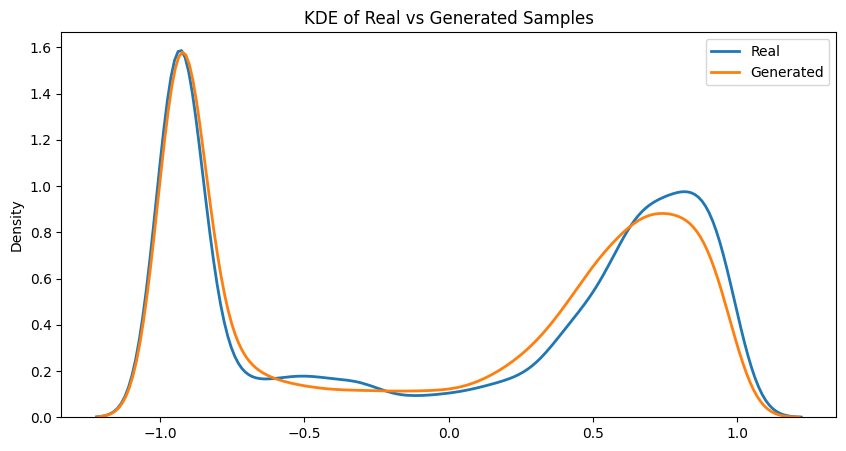

In [ ]:
!pip install dtaidistance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from dtaidistance import dtw
import seaborn as sns

# --- Paramètres ---
NOISE_DIM = 64
num_samples = 100  # Nombre d'échantillons à comparer

# --- Chargement des données réelles ---
data_path = "/content/drive/MyDrive/controls_right/controls_all_right.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# --- Générateur ---
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# --- Chargement du générateur préentraîné ---
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/controls_right/saved_models_controls_right/generator_epoch_70.weights.h5')

# --- Génération des échantillons ---
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# --- MMD ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = real_samples.reshape(real_samples.shape[0], -1)
fake_flat = generated_samples.reshape(generated_samples.shape[0], -1)

mmd_score = compute_mmd(real_flat, fake_flat, gamma=0.1)
print("📏 MMD Score:", mmd_score)

# --- DTW ---
def compute_average_dtw(real_samples, generated_samples):
    dtw_distances = []
    for r, g in zip(real_samples, generated_samples):
        dist = dtw.distance(r.flatten(), g.flatten())
        dtw_distances.append(dist)
    return np.mean(dtw_distances)

dtw_score = compute_average_dtw(real_samples, generated_samples)
print("🔄 Average DTW Distance:", dtw_score)

# --- Cross-Correlation ---
def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return np.correlate(a, b, mode='valid')[0] / len(a)

ccs = [cross_correlation(r.flatten(), g.flatten()) for r, g in zip(real_samples, generated_samples)]
print("🔁 Average Cross-Correlation:", np.mean(ccs))

# --- Visualisation KDE ---
plt.figure(figsize=(10, 5))
sns.kdeplot(real_samples.reshape(-1), label="Real", linewidth=2)
sns.kdeplot(generated_samples.reshape(-1), label="Generated", linewidth=2)
plt.legend()
plt.title("KDE of Real vs Generated Samples")
plt.show()
